In [1]:
# A bit of setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Let's explore the numpy random number generators

We'll try out the numpy module to provide a range of random number generation options.  As you'll learn, the easiest distribution to produce is a uniform distribution over some range, typically [0,1).  This distribution can be easily modified mathematically to produce arbitrary random distributions.

For now, let's just exercise numpy to create uniform and Gaussian distributions.  

### numpy default random number generator (rng)
Generate one random number over the range [0,1)
```
rng = np.random.default_rng()
print("Random number: ", rng.random())
```

### generate an array of 5 integers uniformly over the range [0,10)
```
rng.integers(low=0,high=10,size=5)
```

### generate an array of 10 numbers according to a unit Gaussian distribution
```
rng.standard_normal(10)
```

In [2]:
rng = np.random.default_rng()
print("Random number: ", rng.random(),"\n")

array1 = rng.integers(low=0,high=10,size=5)
print("Five random numbers: ",array1,"\n")

array2 = rng.standard_normal(10)
print("Ten random numbers from a unit normal (Gaussian):\n",array2,"\n")

Random number:  0.5118082122627873 

Five random numbers:  [5 8 3 0 6] 

Ten random numbers from a unit normal (Gaussian):
 [ 0.77613057  0.39238804 -1.41052066  1.00363589 -0.66706332  0.77259661
  1.17134107 -0.76552961 -1.45113535 -0.23446944] 



# Now let's write some code to exercise functions of random variables

### We will imagine that we are accelerating protons

Thus, we'll simulate one proton at a time being accelerated through some naive, imaginaary accelerator chain.  We will analyze the 6-dimentional space they occupy at the end of the process.

The vision will be that the protons are "born" with non-zero momentum at x=y=z=0.  We will then propagate them through space to an accelerator element, accelerate them along a programmable axis, then repeat the process.  

We can inject noise into the accelerator, forcing the protons to acquire a random momentum change along each axis.  Thus, in the end they will have non-zero momentum in each direction and will therefore spread out in space away from their original flight axis.

We will need some helper functions, which we can define in advance.

In [3]:
# these are protons!
# why are we using these numbers??
def mass():
    return 938

def mass_squared():
    return 938*938

def q():
    return np.sqrt(4*np.pi*0.007297)

def gamma(px,py,pz):
    p2 = px*px + py*py + pz*pz
    g = np.sqrt(1 + p2/mass_squared())
    return g

def beta(px,py,pz):
    g = gamma(px,py,pz)
    return np.sqrt(1-1/(g*g))

def energy(px,py,pz):
    return np.sqrt(mass_squared() + px*px + py*py + pz*pz)

def velocity(p,g):
    return p/g/mass()

# This function will generate a random momentum change from a Gaussian distributions
def addMomentumGaussianNoise(p, sigmaP):
    if p < 5:
        return 5*np.random.normal(0,sigmaP)    
    else:
        return p*np.random.normal(0,sigmaP)

# This function will generate a random momentum change from a uniform distributions
# Why choose this form?  What does it do?
def addMomentumUniformNoise(p, sigmaP):
    if p < 5:
        return 5*sigmaP*(np.random.random()-0.5)
    else:
        return p*sigmaP*(np.random.random()-0.5)

# Define some accelerator elements
    # L in meters, E (effective electric field) in mega Volts
    # momentum in MeV
    # position in meters
def accelerator_element(x,y,z,px, py, pz, sigma_px, sigma_py, sigma_pz, L, Ex,Ey,Ez):
    # we are relativisitic, so we need this info!
    g = gamma(px,py,pz)
    b = beta(px,py,pz)
    e = energy(px,py,pz)

    # These variables set the axis of acceleration
    phi = 0  #azimuthal acceleration angle
    theta = 0  #longitudinal acceleration angle 

    # Propagate the protons over the length of the accelerator
    # This ignores the fact that momentum is changing!  How would you fix that
    _dz = L*np.cos(phi)
    _dx = L*np.sin(phi)*np.cos(theta)
    _dy = L*np.sin(phi)*np.sin(theta)

    # increment the position
    x += _dx
    y += _dy
    z += _dz
    
    # calculate velocities
    vx = velocity(px,g)
    vy = velocity(py,g)
    vz = velocity(pz,g)

    # Accelerate!
    _vx = np.sqrt(vx*vx + 2*q()*Ex/mass()*_dx)
    _vy = np.sqrt(vy*vy + 2*q()*Ey/mass()*_dy)
    _vz = np.sqrt(vz*vz + 2*q()*Ez/mass()*_dz)

    # Calculate new momenta
    vv = _vx*_vx + _vy*_vy + _vz*_vz
    _g = 1/np.sqrt(1 - vv)
    px = _g*_vx*mass()
    py = _g*_vy*mass()
    pz = _g*_vz*mass()

    # Add momentum noise
    px += addMomentumGaussianNoise(px,sigma_px)
    py += addMomentumUniformNoise(py,sigma_py)
    pz += addMomentumGaussianNoise(pz,sigma_pz)
    
    return x,y,z,px,py,pz


# propagate through space
    # position in meters
    # t in nanoseconds
def propagate(x,y,z,px,py,pz,t):
    g = gamma(px,py,pz)
    x += velocity(px,g)*t
    y += velocity(py,g)*t
    z += velocity(pz,g)*t
    return x, y, z

# build a particle accelerator!
def accelerate(x,y,z,px,py,pz):

    # propagate in space for 100 nsec
    x,y,z = propagate(x,y,z,px,py,pz, 100)
    
    # start with acceleration
    x,y,z,px,py,pz = accelerator_element(x,y,z,px,py,pz, 0.2, 0.2, 0.01, 2, 0,0,10)

    # propagate in space for 100 nsec
    x,y,z = propagate(x,y,z,px,py,pz, 100)
    
    # second stage of acceleration
    x,y,z,px,py,pz = accelerator_element(x,y,z,px,py,pz, 0.2, 0.2, 0.01, 2, 0,0,10)

    # propagate in space for 100 nsec
    x,y,z = propagate(x,y,z,px,py,pz, 100)
    
    return x,y,z,px,py,pz

In [4]:
# one particle
x,y,z = 0,0,0
px,py,pz = 0, 0, 50
accelerate(x,y,z,px,py,pz)

(-0.004674806772059892,
 0.07119733567140912,
 38.52255222824611,
 0.7110313360914453,
 0.21827581040841043,
 159.44172767943465)

In [5]:
# many particles!
Niter = 10000
xx = np.zeros(Niter)
yy = np.zeros(Niter)
zz = np.zeros(Niter)
ppx = np.zeros(Niter)
ppy = np.zeros(Niter)
ppz = np.zeros(Niter)
for i in range(Niter):
    x,y,z = 0,0,0
    px,py,pz = 0, 0, 50
    xx[i], yy[i], zz[i], ppx[i], ppy[i], ppz[i] = accelerate(x,y,z,px,py,pz)

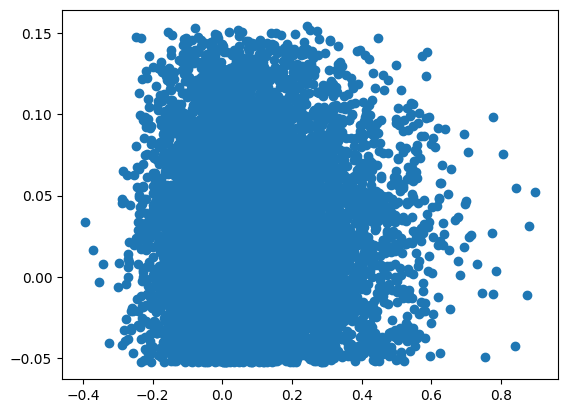

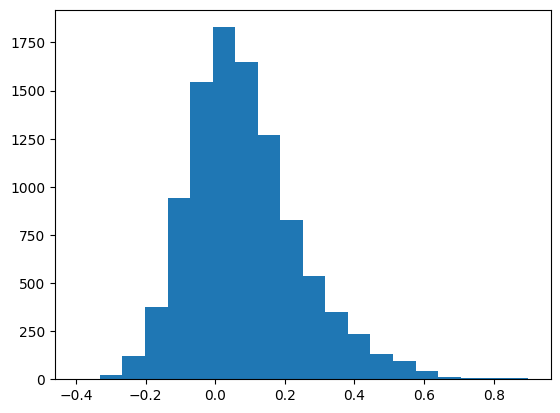

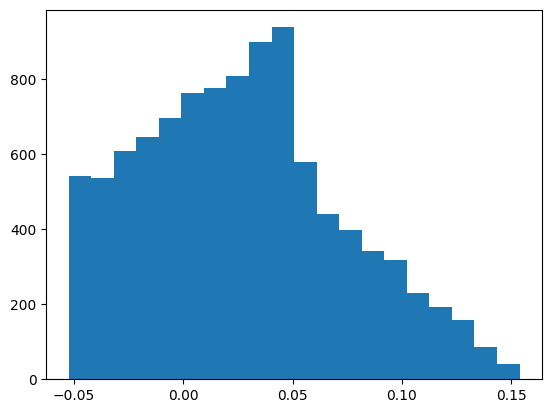

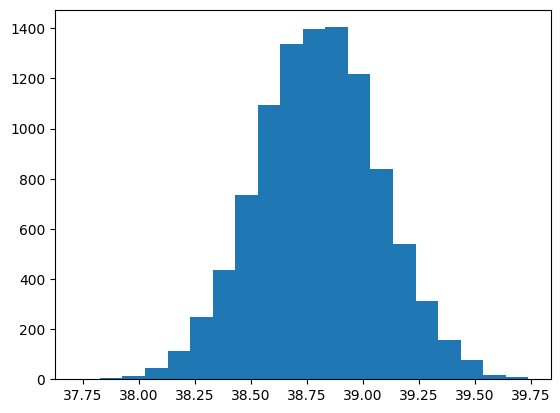

In [6]:
# let's illustrate what we got
plt.scatter(xx,yy)
plt.show()
plt.hist(xx,bins=20)
plt.show()
plt.hist(yy,bins=20)
plt.show()
plt.hist(zz,bins=20)
plt.show()

# Now let's analyze our distributions

### We may want to know something about the moments of our distributions!
The mean, variance, and standard deviations would be great to know.  So we'll calculate them.

But as you can see, the distributions are asymmetric, so we should also calculate some higher moments to capture the nature of this asymmetry.

### Moments

mean: $E[x]$

variance: $E[(x- \mu)^2]$

Skew: $E[(x- \mu)^3] / \sigma^3$

Kurtosis: $E[(x- \mu)^4] / \sigma^4$

In [21]:
import scipy as scipy

# Calculate mean:
def getMean(xx, doPrint=True):
    mean = np.sum(xx)/np.size(xx)
    if doPrint:
        #print("Mean: ", mean, " , ", np.mean(xx))
        print("Mean: %.4f, %.4f" % (mean, np.mean(xx)))
    return mean

# Calculate variance:
def getVariance(xx, doPrint=True): 
    mean = getMean(xx, doPrint=False)
    var = np.sum(xx*xx)/np.size(xx) - mean*mean
    sigma = np.sqrt(var)
    if doPrint:
        #print("Variance: ", var, " , ", np.var(xx))
        print("Variance: %.4f, %.4f" % (var, np.var(xx)))
    return sigma
    
# Calculate skew
def getSkew(xx):
    sigma = getVariance(xx, doPrint=False)
    mean = getMean(xx, doPrint=False)
    skewX = np.power(xx - mean,3)
    skew = np.sum(skewX)/np.size(xx)
    skew = skew/np.power(sigma,3)
    #print("Skew: ", skew, " , ", scipy.stats.skew(xx))
    print("Skew: %.4f, %.4f" % (skew, scipy.stats.skew(xx)))

# Calculate kurtosis
def getKurtosis(xx):
    sigma = getVariance(xx, doPrint=False)
    mean = getMean(xx, doPrint=False)
    kurtX = np.power(xx - mean,4)
    kurt = np.sum(kurtX)/np.size(xx)
    kurt = kurt/np.power(sigma,4)
    #print("Kurtosis: ", kurt, " , ", scipy.stats.kurtosis(xx, fisher=False))
    print("Kurtosis: %.4f, %.4f" % (kurt, scipy.stats.kurtosis(xx, fisher=False)))
    

In [22]:
getMean(xx)
getMean(yy)
getMean(zz)

Mean: 0.0850, 0.0850
Mean: 0.0270, 0.0270
Mean: 38.8024, 38.8024


38.80239815960472

In [23]:
getVariance(xx)
getVariance(yy)
getVariance(zz)

Variance: 0.0257, 0.0257
Variance: 0.0021, 0.0021
Variance: 0.0745, 0.0745


0.2730037621992423

In [24]:
getSkew(xx)
getSkew(yy)
getSkew(zz)

Skew: 0.7733, 0.7733
Skew: 0.3564, 0.3564
Skew: -0.0052, -0.0052


In [25]:
getKurtosis(xx)
getKurtosis(yy)
getKurtosis(zz)

Kurtosis: 3.9688, 3.9688
Kurtosis: 2.5011, 2.5011
Kurtosis: 2.9624, 2.9624
